In [321]:
import codecs
import numpy as np
import gensim
import io
import sys
import codecs
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, LSTM, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder

# Data preprocessing

In [322]:
text_name = "data_for_lab5/potter_no_signs.txt"
with codecs.open(text_name, encoding= 'utf-8', mode='r') as f:
    docs = f.readlines()#.replace("\r\n", " ")

In [323]:
max_sentence_len = 20
sentences = [sent for doc in docs for sent in doc.split('.')]
sentences = [[word for word in sent.lower().split()[:max_sentence_len]] for sent in sentences]
print(len(sentences), 'предложений')

28242 предложений


# Model training

In [324]:
word_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, epochs=200)
word_model.save("word2vec.model")

In [125]:
print('Похожие слова:')
for word in ['гермиона', 'гарри', 'палочка', 'собака', 'зелье','турнир','кубок']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

Похожие слова:
  гермиона -> она (0.63), полумна (0.54), анджелина (0.45), чжоу (0.43), амбридж (0.42), лаванда (0.40), тонкс (0.38), ты (0.38)
  гарри -> он (0.88), и (0.76), в (0.66), не (0.66), на (0.63), что (0.62), я (0.56), но (0.56)
  палочка -> волшебная (0.64), красовались (0.59), перекрещенные (0.58), кость (0.56), скрещенные (0.56), подбородок (0.53), направленная (0.52), испускала (0.52)
  собака -> укусит (0.72), ровен (0.69), залаяла (0.65), исступленно (0.56), приветствую (0.53), стереосистема (0.53), магла (0.52), подашь (0.51)
  зелье -> свертывалось (0.54), максимальное (0.54), оборотном (0.52), строение (0.50), кропотливой (0.47), крововосполняющее (0.47), взгляд: (0.45), неожиданных (0.45)
  турнир -> родословная (0.72), полезные (0.63), лаются (0.63), оскорблений (0.63), юных (0.63), учреждениях (0.62), раскошеливайтесь (0.61), чрезвычайной (0.61)
  кубок -> вина (0.52), шумок (0.49), глотнуть (0.46), по-сонному (0.46), привыкла (0.44), спутанным (0.43), разыгрывал

In [126]:
matrix =np.array(word_model.wv.get_vector('палочка'))

In [127]:
vec = word_model.wv.get_vector('слизерин') + word_model.wv.get_vector('малфой') 
word_model.wv.similar_by_vector(vec)

[('малфой', 0.9537742137908936),
 ('обормоттер', 0.4360995292663574),
 ('у-тю-тю', 0.43593549728393555),
 ('драгоценный', 0.39384493231773376),
 ('де-мен-то-ра', 0.3935497999191284),
 ('изловить', 0.3921833634376526),
 ('пса', 0.39108559489250183),
 ('слизерин', 0.390460342168808),
 ('занавес', 0.3862284719944),
 ('оборзел', 0.3801157474517822)]

In [128]:
df = pd.read_csv('./data_for_lab5/production.csv')
df.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


In [129]:
input_params = df.groupby('API')[['Liquid', 'Gas', 'Water']].apply(lambda df_: df_.reset_index(drop=True))
input_params.head()

Liquid    Gas  Water
API                                  
5005072170100 0    9783  11470  10558
              1   24206  26476   5719
              2   20449  26381   2196
              3    6820  10390    583
              4    7349   7005    122

In [130]:
df_prod = input_params.unstack()
df_prod.head()

Liquid                                                       \
                  0      1      2     3     4      5      6      7     8    
API                                                                         
5005072170100   9783  24206  20449  6820  7349  16552  13844  10655  6135   
5123377130000   2341   4689   3056  1979  2037   2260   1961   1549  1364   
5123379280000   6326   6405   6839  6584  4775   3917   3840   3031  3137   
5123379400000   8644  13977   9325  6445  5326   4538   3403   2534  2685   
5123385820100   1753   4402   1187  1204  1176   1523   1169    782   634   

                      ... Water                                               
                  9   ...    14   15   16   17   18   19   20   21   22   23  
API                   ...                                                     
5005072170100  11105  ...   357  270  242  236  250  200  241  215  194  188  
5123377130000   1380  ...   193  118  111  111   91  100  137  109  113   55  
5123379280000   2669  ...   218  256  203  207  225  180  194  202  182  208  
5123379400000   2597  ...   197  156  193  226  135  190  162  181  189   34  
5123385820100    597  ...   124    0    0    0    0    0  119  568  521  289  

[5 rows x 72 columns]

In [131]:
data = df_prod.values
data = data / data.max()
data = data[:, :, np.newaxis]

data_tr = data[:40]
data_tst = data[40:]
data_tr = data_tr.reshape(40, 24, 3)
data_tst = data_tst.reshape(10, 24, 3)

print(data_tr.shape, data_tst.shape)

(40, 24, 3) (10, 24, 3)


In [132]:
x_data = [data_tr[:, i:i+12] for i in range(11)]
y_data = [data_tr[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [133]:
timesteps = 12
inp = Input(shape=(timesteps, 3))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(3, activation="relu")(lstm)

model = Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 12, 32)            4608      
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 32)            8320      
_________________________________________________________________
dense_6 (Dense)              (None, 12, 3)             99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.fit(x_data, y_data, epochs=20)

Epoch 1/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0049 - mae: 0.0440
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0039 - mae: 0.0395
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0035 - mae: 0.0382
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0032 - mae: 0.0355
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0030 - mae: 0.0360
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0029 - mae: 0.0341
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0028 - mae: 0.0327
Epoch 8/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0027 - mae: 0.0323
Epoch 9/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0026 - mae: 0.0312
Epoch 10/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0026 - mae: 0.0312
Epoch 11/20
14/14 [==============================] - 0s 7ms/step - lo

In [135]:
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))
print(predicts.shape)
for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    pred = model.predict(x)
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)

(10, 0, 3)


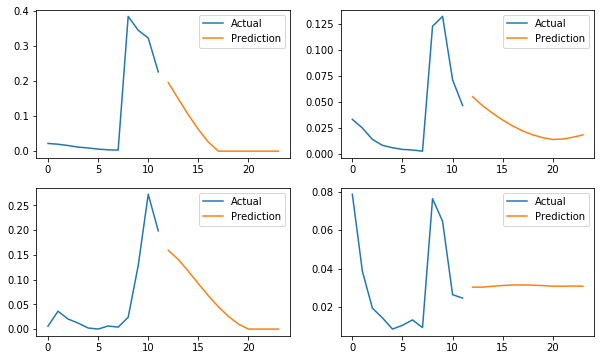

In [136]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[i, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[i, :, 0], label='Prediction')
    plt.legend()
plt.show()

In [137]:
text_name = "data_for_lab5/potter_short.txt"
with codecs.open(text_name, encoding= 'utf-8', mode='r') as f:
    short_text = f.read(2000)
short_text = short_text.lower()
print(short_text)
print(len(short_text))

джоан роулинг    гарри поттер и орден феникса       глава 1. дадли досталось     самый пока что жаркий день знойного лета клонился к вечеру  и большие прямоугольные дома тисовой улицы окутывала сонная тишина. машины  обычно сверкавшие чистотой  стояли пыльные  а лужайки были уже не изумрудно зелеными  а иссохшими  желтоватыми из за нехватки воды жителям запретили пользоваться шлангами. лишенные таких важных занятий  как мытье машин и стрижка газонов  обитатели тисовой сидели по комнатам  где было чуть прохладней  широко распахнув окна в несбыточной надежде на освежающее дуновение. единственным  кто не находился дома  был подросток  лежавший лицом вверх на цветочной клумбе у дома номер четыре.    это был худой  черноволосый парнишка в очках  чуть болезненный и угловатый на вид    посмотришь  и сразу ясно  что он сильно вытянулся за короткое время. джинсы рваные и грязные  футболка мешковатая и выцветшая  кроссовки скоро запросят каши. одним словом  наружность гарри поттера не красила ег

In [141]:
chars = sorted(list(set(short_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

char_to_index = {v:i for i,v in enumerate(chars)}
index_to_char = {i:v for i,v in enumerate(chars)}
n_chars = len(short_text)
encoding_size = len(chars)

print("Total characters:", n_chars)
print("Encoding size:", encoding_size)

print(int_to_char)

Total characters: 2000
Encoding size: 34
{0: ' ', 1: '.', 2: '1', 3: 'а', 4: 'б', 5: 'в', 6: 'г', 7: 'д', 8: 'е', 9: 'ж', 10: 'з', 11: 'и', 12: 'й', 13: 'к', 14: 'л', 15: 'м', 16: 'н', 17: 'о', 18: 'п', 19: 'р', 20: 'с', 21: 'т', 22: 'у', 23: 'ф', 24: 'х', 25: 'ц', 26: 'ч', 27: 'ш', 28: 'щ', 29: 'ы', 30: 'ь', 31: 'э', 32: 'ю', 33: 'я'}


In [225]:
alphabet = [chr(i) for i in range(ord('а'), ord('я')+1)] + ['ё', ' ','1','.']
print(f'Alphabet size: {len(alphabet)}')
print(''.join(alphabet))

Alphabet size: 36
абвгдежзийклмнопрстуфхцчшщъыьэюяё 1.


In [235]:
sentence_len = 50
#sentences_x = [short_text[i:i+sentence_len] for i in range(0,len(short_text), sentence_len)]
#sentences_y = [short_text[i] for i in range(sentence_len,len(short_text), sentence_len)]
sentence_x = []
sentence_y = []
for i in range(0, len(short_text) - sentence_len, sentence_len):
    seq_in = short_text[i:i + sentence_len]
    seq_out = short_text[i + sentence_len]
    #sentence_x.append([char_to_int[char] for char in seq_in])
    #sentence_y.append(char_to_int[seq_out])
    sentence_x.append(seq_in)
    sentence_y.append(seq_out)
n_sentences = len(sentences_x)
#print(n_sentences)
#print(len(sentences_y))
print(sentence_x[10])
print(sentence_y[10])

о чуть прохладней  широко распахнув окна в несбыто
ч


In [264]:
def encode_char(ch, alphabet):
    # Create encoder vector
    vec = [0] * len(alphabet)
    vec[alphabet.index(ch)] = 1
    return vec

def encode_line(line, alphabet):
    return [encode_char(ch, alphabet) for ch in line]

def encline2str(encline, alphabet):
    # encline - encoded 2d array
    ixs = np.max(encline.argmax(axis=1))  # index where 1 or max prob
    print(ixs)
    chars = alphabet[ixs]  # encoded indices to char
    return ''.join(chars)

In [353]:
encoded_x = [encode_line(line, alphabet) for line in sentence_x]
encoded_y = [encode_char(line, alphabet) for line in sentence_y]
encoded_x = np.array(encoded_x)
print(encoded_x.shape)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(39, 50, 36)
(39, 36)


# Define RNN

In [354]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model_rnn = Sequential()
model_rnn.add(LSTM(512, activation='softmax', input_shape=(encoded_x.shape[1], encoded_x.shape[2])))
#model_rnn.add(LSTM(32, activation='softmax',input_shape = encoded_y.shape[1]))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(encoded_y.shape[1], activation="sigmoid"))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy')
model_rnn.summary()
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam')
model_rnn.fit(encoded_x, encoded_y, epochs=25, batch_size=128)


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 512)               1124352   
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 36)                18468     
Total params: 1,142,820
Trainable params: 1,142,820
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1/1 [==============================] - 0s 2ms/step - loss: 3.5833
Epoch 2/25
1/1 [==============================] - 0s 2ms/step - loss: 3.5823
Epoch 3/25
1/1 [==============================] - 0s 1ms/step - loss: 3.5813
Epoch 4/25
1/1 [==============================] - 0s 998us/step - loss: 3.5805
Epoch 5/25
1/1 [==============================] - 0s 1ms/step -

In [347]:
model_rnn.save_weights('simpleRNN_3pred.h5')

In [348]:
def predict_next_char(inp):
    print(inp)
    index = [encode_line(line, alphabet) for line in inp]
    prediction = model_rnn.predict(np.array(index))
    return (encline2str(prediction,alphabet))
    

In [351]:
predict_next_char('гарр')

гарр
8


'и'